## Requirements

In [3]:
!git clone https://github.com/VikParuchuri/tabled.git


Cloning into 'tabled'...


In [4]:
%cd tabled

d:\Internship\Nepali-Sentiment-Classification\NepaliSentiment\tabled


d:\Internship\Nepali-Sentiment-Classification\NepaliSentiment\myenv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
%pip install .

Processing d:\internship\nepali-sentiment-classification\nepalisentiment\tabled
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for tabled-pdf: filename=tabled_pdf-0.2.0-py3-none-any.whl size=31892 sha256=e01d08bc44fd13a93446c34ad65534235c1b7bc56978d6b29c6405fba8c193a2
  Stored in directory: C:\Users\Anup Acharya\AppData\Local\Temp\pip-ephem-wheel-cache-dfarpc__\wheels\ba\0f\df\9d4df7b4944bbba9ead1ee5a98d5282dd6f032a6839e58a9f4
Successfully built tabled-pdf
  Attempting uninstall: pdftext
    Found existing installation: pdftext 0.3.20
    Uninstalling pdftext-0.3.20:
      Successfully uninstalled pdftext-0.3.20
  Attempting uninstall: surya-ocr
    Found existing installation: surya-ocr 0.7.0
    Uninstalling

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the 'd:\Internship\Nepali-Sentiment-Classification\NepaliSentiment\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
# For Google Colab
import os
os.chdir('/content')

# For local env use 
# %cd ..

FileNotFoundError: [WinError 2] The system cannot find the file specified: '/content'

In [7]:
%pip install pdf2image
# !apt-get install -y poppler-utils # For Google Colab
# For local environment install poppler-utils and add to path

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Internship\Nepali-Sentiment-Classification\NepaliSentiment\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [8]:
# Important for memory management
# Change the batch sizes according to available GPU resources

# Define the batch size variables
batch_sizes = {
    'TABLE_REC_BATCH_SIZE': 4,
    'RECOGNITION_BATCH_SIZE': 8,
    'DETECTOR_BATCH_SIZE': 4,
    'LAYOUT_BATCH_SIZE': 2
}

file_path = "local.env"

# Create a .env file and write the variables
with open(file_path, 'w') as f:
    # Iterate over the batch sizes dictionary and write each one
    for key, value in batch_sizes.items():
        # Write each variable in the format KEY=VALUE
        f.write(f'{key} = {value}\n')

## Imports

In [ ]:
# Import necessary libraries
from tabulate import tabulate
import pandas as pd
from pdf2image import convert_from_path
from PIL import Image
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import tempfile
import os

# Impoer required models
from surya.model.detection.model import load_model as load_det_model, load_processor as load_det_processor
from surya.model.recognition.model import load_model as load_rec_model
from surya.model.recognition.processor import load_processor as load_rec_processor
from tabled.inference.models import load_layout_models
from surya.model.table_rec.model import load_model as load_table_rec_model
from surya.model.table_rec.processor import load_processor as load_table_rec_processor

# Import Required Functions
from tabled.tabled.extract import extract_tables    # if any error use tabled.extract instead of tabled.tabled.extract
from tabled.fileinput import load_pdfs_images
from surya.ocr import run_ocr

In [3]:
import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

CUDA Available: True


## Model Initialization

In [2]:
langs = ["en","ne"]
det_processor, det_model = load_det_processor(), load_det_model()
rec_model, rec_processor = load_rec_model(), load_rec_processor()
layout_models = load_layout_models()
det_models = det_model,det_processor
rec_models = load_table_rec_model(),load_table_rec_processor(),rec_model,rec_processor

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded layout model datalab-to/surya_layout0 on device cuda with dtype torch.float16
Loaded table recognition model vikp/surya_tablerec on device cuda with dtype torch.float16


## Function to crop images

### Detecting tables in a page using OpenCV

In [3]:
def retrieve_table_boudaries(image):

    # image will be in PIL image format
    opencv_image = np.array(image)


   # Convert image to grayscale
    gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    kernel = np.ones((7, 7), np.uint8) 
    morph_image = cv2.dilate(edges, kernel, iterations=1)

    # Find contours
    contours, hierarchy = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    probable_tables = []
    for contour in contours:
      # Approximate the contour to a polygon (to simplify it)
      epsilon = 0.02 * cv2.arcLength(contour, True)
      approx = cv2.approxPolyDP(contour, epsilon, True)

      # If the contour has four vertices, it’s likely a table boundary
      if len(approx) == 4:
        probable_tables.append(approx)

    output_tables = []

    for contour in probable_tables:
      area = cv2.contourArea(contour)
      # print(area)
      if area > 100000:
        print(area)
        x, y, w, h = cv2.boundingRect(contour)
        table = [x, y, (x+w), (y+h)]
        # table = [x, y, (x+w), (y+h)]
        output_tables.append(table)

    output_tables = sorted(output_tables, key=lambda x: x[1])

    # print("check 2")
    # print(opencv_image.shape)
    print("Length of table:")
    print(len(output_tables))
    return output_tables,opencv_image

In [ ]:
tables

[[104, 83, 701, 144], [104, 346, 701, 520]]

#### Testing

In [ ]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow

In [29]:
image = cv2.imread("/content/two_table.png")
tables = retrieve_table_boudaries(image)

In [ ]:
for table in tables:
  cv2.rectangle(image,(table[0],table[1]),(table[2],table[3]),(255, 0, 0), 2)

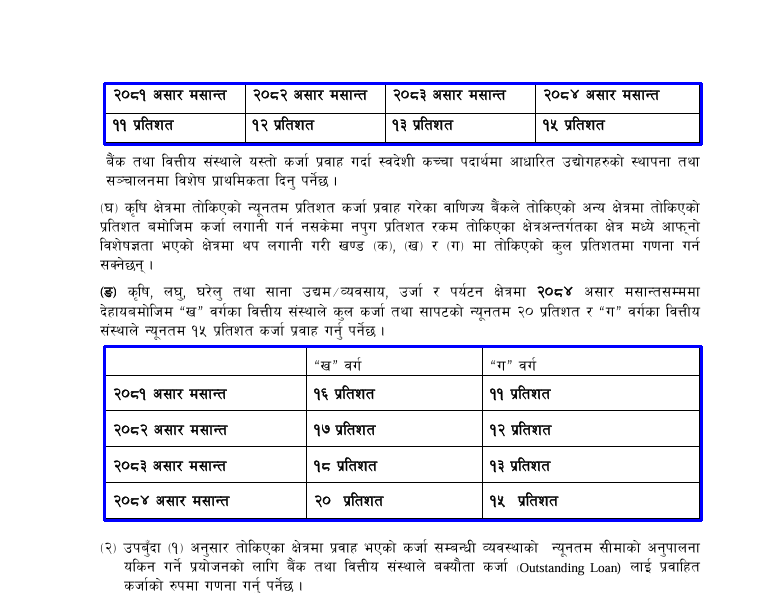

In [ ]:
cv2_imshow(image)

In [143]:
image = cv2.imread("/content/table_test_new.png")
tables,image = retrieve_table_boudaries(image)

In [134]:
tables

[[112, 235, 721, 384]]

In [144]:
for table in tables:
  cv2.rectangle(image,(table[0],table[1]),(table[2],table[3]),(255, 0, 0), 2)

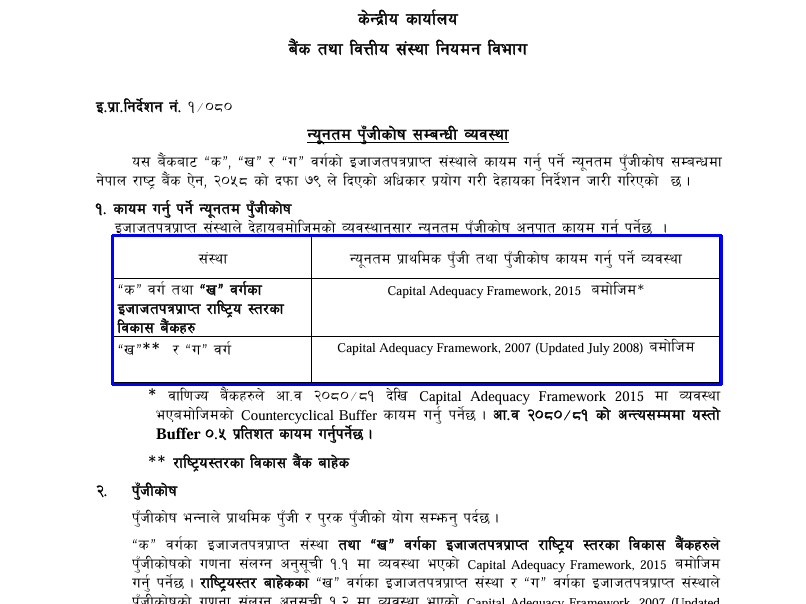

In [145]:
cv2_imshow(image)

In [146]:
image.shape

(604, 806, 3)

In [100]:
start_page = 147
end_page = 147

file_path = "new.txt"
images = convert_from_path("Unified-Directives-2080-Circular-Final-Published.pdf", dpi=300,first_page=start_page, last_page=end_page)

In [101]:
tables,opencv_image = retrieve_table_boudaries(images[0])

1010289.0
357889.0
Length of table:
2


In [72]:
len(tables)

4

In [102]:
for table in tables:
  cv2.rectangle(opencv_image,(table[0],table[1]),(table[2],table[3]),(255, 0, 0), 2)


In [81]:
opencv_image.shape

(3300, 2550, 3)

In [103]:
resized_image = cv2.resize(opencv_image, (1280, 780))
cv2.imshow("Image",resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Cropping Image

In [4]:
# Define padding sizes (top, bottom, left, right)
top_padding = 200  # pixels
bottom_padding = 200
left_padding = 0
right_padding = 0
padding_color = (255, 255, 255)

In [5]:
def crop_images(image,tables):
  if len(tables) == 0:
    image_data = {
        'image': image,
        'table':0
    }
    return [image_data]

  # print("WE are at crop_images")
  height,width = image.shape[:2]
  # print(height,width)

  cropped_images = []
  # Cropping table

  cropped_image = image[0:tables[0][1],0:width]  # [y_min:y_max, x_min:x_max]
  image_data = {
      'image' : cropped_image,
      'table' : 0
  }
  cropped_images.append(image_data)

  break_point = tables[0][1]
  for table in tables:
    if table[1] != break_point:
      cropped_image = image[break_point:table[1],0:width]
      image_data = {
        'image' : cropped_image,
        'table' : 0
      }
      cropped_images.append(image_data)

    cropped_image = image[table[1]-100:table[3]+100, 0:width]
    padded_image = cv2.copyMakeBorder(
        cropped_image,
        top_padding, bottom_padding, left_padding, right_padding,
        borderType=cv2.BORDER_CONSTANT,
        value=padding_color
    )
    image_data = {
        'image':padded_image,
        'table':1
    }
    cropped_images.append(image_data)

    break_point = table[3]

  cropped_image = image[tables[-1][3]:height, 0:width]
  image_data = {
      'image':cropped_image,
      'table':0
  }
  cropped_images.append(image_data)

  return cropped_images

#### Testing

##### Test 1

0


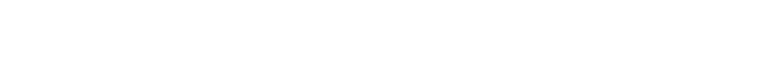

1


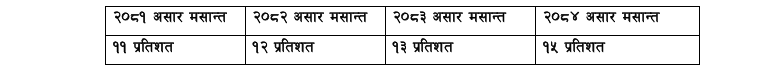

0


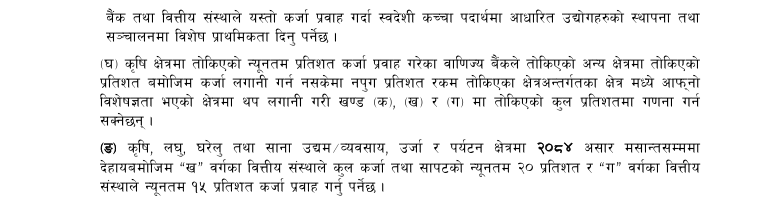

1


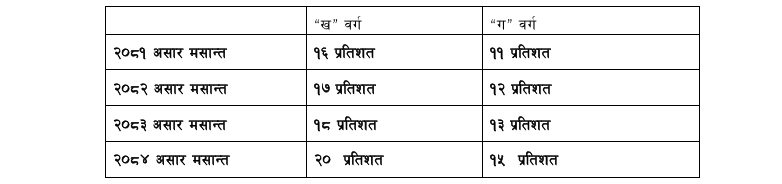

0


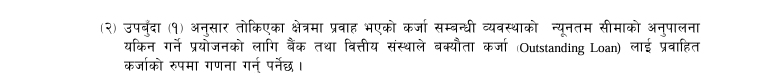

In [31]:
image = cv2.imread("/content/two_table.png")
tables = retrieve_table_boudaries(image)

for image in crop_images(image,tables):

  print(image['table'])
  cv2_imshow(image['image'])

##### Test 2

## Recognizing Text

### For Tabular Data

In [6]:
def table_data(image,file_path):
  image_pil = Image.fromarray(image['image'])
  with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_file:
      temp_path = temp_file.name  # Get the temporary file path
      image_pil.save(temp_path)

  # cv2_imshow(temp_path)
  images, highres_images, names, text_lines = load_pdfs_images(temp_path)
  os.remove(temp_path)

  page_results = extract_tables(images, highres_images, text_lines, det_models, layout_models, rec_models)

  if len(page_results[0].cells) == 0:
    normal_data(image,file_path)
    return

  # page_results[0].cells

  results = page_results[0].cells[0]

  table_list = []

  for result in results:
    span = []
    span.append(result.text)
    span.append(result.row_ids[0])
    span.append(result.col_ids[0])
    table_list.append(span)

  max_row = max(item[1] for item in table_list)
  max_col = max(item[2] for item in table_list)

  table = [["" for _ in range(max_col + 1)] for _ in range(max_row + 1)]

  for value, row, col in table_list:
      table[row][col] = value

  df = pd.DataFrame(table)
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
  column_widths = [max(df[col].astype(str).map(len)) for col in df.columns]

  # Align text to the left for each column
  formatted_rows = []
  for _, row in df.iterrows():
    formatted_row = " | ".join(
        f"{str(row[col]).ljust(column_widths[col])}" for col in df.columns
    )
    formatted_rows.append(formatted_row)

  # table_data = df.values.tolist()
  # formatted_table = tabulate(table_data, tablefmt="psql")

  with open(file_path, "a", encoding="utf-8") as f:
    f.write("\n".join(formatted_rows))

      # f.write(f"\n{formatted_table}\n\n")

### For Normal Data

In [7]:
def normal_data(image,file_path):
  # file_path = "ocr_test.txt"
  image_pil = Image.fromarray(image['image'])
  width,height = image_pil.size
  if height == 0:
    return
  # print(f"Width: {width}, Height: {height}")
  # print("i am here")
  predictions = run_ocr([image_pil], [langs], det_model, det_processor, rec_model, rec_processor)
  pred_list = list(predictions[0])
  cleaned_text = pred_list[0][1]
  with open(file_path,"a",encoding="utf-8") as file:
      # file.write(f"\n\nPage {i+1}\n")
      for line in cleaned_text:
          file.write(f"{line.text}\n")

In [26]:
%cd ..

d:\Internship\Nepali-Sentiment-Classification\NepaliSentiment


d:\Internship\Nepali-Sentiment-Classification\NepaliSentiment\myenv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Test

In [11]:
import time

start_time = time.time()

# start_page = 1
# end_page = 300

file_path = "Page_140_to_180.txt"

print("Image Extraction Completed")
for i in range(140,181):
  images = convert_from_path("Unified-Directives-2080-Circular-Final-Published.pdf", dpi=300,first_page=i, last_page=i) # Each page converted individually to avoid resources issues
  print(f"Page {i}")
  tables,opencv_image = retrieve_table_boudaries(images[0])
  cropped_images = crop_images(opencv_image,tables)
  # cv2_imshow(cropped_images[1]['image'])
  for image in cropped_images:
    if image['table']:
      table_data(image,file_path)
    else:
      normal_data(image,file_path)
  with open(file_path,"a",encoding="utf-8") as file:
    # file.write(f"\n\nPage {i+1}\n")
    file.write(f"Page {i+1}\n\n")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.5f} seconds")

Image Extraction Completed
Page 140
Length of table:
0


Recognizing Text: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]


Page 141
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


Page 142
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


Page 143
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]


Page 144
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:30<00:00,  5.11s/it]


Page 145
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]


Page 146
395169.0
357889.0
Length of table:
2


Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Page 147
1010289.0
357889.0
Length of table:
2


Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


Page 148
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:31<00:00,  5.24s/it]


Page 149
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Page 150
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


Page 151
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


Page 152
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


Page 153
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:29<00:00,  4.86s/it]


Page 154
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:28<00:00,  5.60s/it]


Page 155
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]


Page 156
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:31<00:00,  5.32s/it]


Page 157
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]


Page 158
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


Page 159
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


Page 160
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]


Page 161
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:30<00:00,  5.07s/it]


Page 162
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


Page 163
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


Page 164
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Page 165
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:30<00:00,  5.06s/it]


Page 166
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:33<00:00,  5.62s/it]


Page 167
617761.0
Length of table:
1


Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Page 168
5243041.0
Length of table:
1


Recognizing tables: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Page 169
2722501.0
Length of table:
1


Recognizing tables: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Page 170
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


Page 171
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:28<00:00,  5.68s/it]


Page 172
Length of table:
0


Recognizing Text: 100%|██████████| 6/6 [00:31<00:00,  5.17s/it]


Page 173
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


Page 174
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


Page 175
Length of table:
0


Recognizing Text: 100%|██████████| 4/4 [00:18<00:00,  4.58s/it]


Page 176
689131.0
Length of table:
1


Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
C:\Users\Anup Acharya\AppData\Local\Temp\ipykernel_18144\2900324173.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Recognizing Text: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Page 177
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


Page 178
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


Page 179
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]


Page 180
Length of table:
0


Recognizing Text: 100%|██████████| 5/5 [00:29<00:00,  5.87s/it]

Elapsed time: 1317.04767 seconds


In [231]:
start_page = 168
end_page = 168

file_path = "output.txt"
images = convert_from_path("/content/Unified-Directives-2080-Circular-Final-Published.pdf", dpi=300,first_page=start_page, last_page=end_page)

In [232]:
tables,opencv_image = retrieve_table_boudaries(images[0])
cropped_images = crop_images(opencv_image,tables)

5215309.0
